# Siamese Neural Network

In [1]:
import io
import os
import numpy as np
import numpy.random as rng

from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

## Load Cifar 10 Dataset

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
(x_train_master, y_train_master), (x_test_master, y_test_master) = cifar10.load_data()

In [15]:
x_train_master = x_train_master / 255.0
x_test_master = x_test_master / 255.0

In [4]:
def loadData(x, y, classes):
  e = []
  for c in range(len(classes)):
    c_idx = [i for i, v in enumerate(y) if v[0] == c]

    r = []
    for se in x[c_idx]:
      i = Image.fromarray(np.uint8(se))
      i = i.resize((150, 150))
      i = np.array(i)
      r.append(i)

    e.append(np.stack(r))

  return np.stack(e)

In [5]:
x_train = loadData(x_train_master, y_train_master, class_names)
x_test = loadData(x_test_master, y_test_master, class_names)

In [6]:
print(x_train.shape)
print(x_test.shape)

(10, 5000, 150, 150, 3)
(10, 1000, 150, 150, 3)


In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

6


'frog'

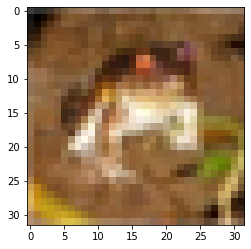

In [7]:
index = 0
plt.imshow(x_train_master[index])
print(y_train_master[index, 0])
class_names[y_train_master[index, 0]]

'deer'

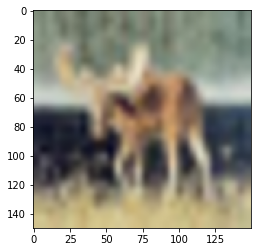

In [15]:
index = 4
example = 3
plt.imshow(x_train[index, example])
class_names[index]

In [9]:
(_, _, w, h, c) = x_train.shape
input_shape = (w, h, c)
print(input_shape)

(150, 150, 3)


## Load Stanford Online Product Dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('stanford_online_products', split='train')

In [ ]:
def convertData(ds):
  x = []
  y = []
  classes = {}

  for e in ds.take(-1):
    image = e["image"].numpy()
    label = "{}".format(e["class_id"].numpy())

    image = Image.fromarray(np.uint8(image))
    image = image.resize((150, 150))
    image = np.array(image)

    x.append(image)
    y.append(label)

    if not label in classes.keys():
      classes[label] = 1
    else:
      classes[label] += 1

  return np.array(x), y, classes

In [ ]:
x_train_master, y_train_master, c_train_master = convertData(ds)
class_names = list(c_train_master.keys())

In [ ]:
def getMinExamplesPerClass(classes):
  min_value = 1000

  for k in c_train_master.keys():
    if c_train_master[k] < min_value:
      min_value = c_train_master[k]

  return min_value

In [ ]:
def loadData(x, y, classes):
  max = getMinExamplesPerClass(classes)
  e = []
  for c in range(len(classes.keys())):
    c_idx = [i for i, v in enumerate(y) if v == "{}".format(c)]
    c_idx = rng.choice(c_idx, max, replace=False)
    e.append(np.stack(x[c_idx]))

  return np.stack(e)

In [ ]:
x_train = loadData(x_train_master, y_train_master, c_train_master)

In [ ]:
index = 4
plt.imshow(x_train_master[index])
class_names[int(y_train_master[index])]

## Load Siamese Model

In [16]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [17]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [18]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    # model = Sequential()
    # model.add(Conv2D(32, 3, padding="same", activation='relu', input_shape=input_shape))
    # model.add(Conv2D(32, 3, padding="same", activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(64, 3, padding="same", activation='relu'))
    # model.add(Conv2D(64, 3, padding="same", activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='sigmoid'))

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, 
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation = 'sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)
    
    # return the model
    return siamese_net

In [19]:
model = get_siamese_model(input_shape)
optimizer = Adam(learning_rate= 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         128089408   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]             

In [ ]:
model = tf.keras.models.load_model("model.h5")

## Train Model

In [20]:
def get_batch(batch_size, s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = x_train
    else:
        X = x_test

    n_classes, n_examples, w, h, c = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes, size=(batch_size,), replace=False)

    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, c)) for i in range(2)]

    # initialize vector for the targets
    targets = np.zeros((batch_size,))

    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1

    for i in range(batch_size):
      category = categories[i]

      idx_1 = rng.randint(0, n_examples)
      pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, c)

      # pick images of same class for 1st half, different for 2nd
      if i >= batch_size // 2:
          category_2 = category  
      else: 
          # add a random number to the category modulo n classes to ensure 2nd image has a different category
          category_2 = (category + rng.randint(1, n_classes)) % n_classes
        
      idx_2 = rng.randint(0, n_examples)
      pairs[1][i,:,:,:] = X[category_2, idx_2].reshape(w, h, c)

    return pairs, targets   

In [23]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield (pairs, targets)

In [22]:
batch_size = 10
epochs = 100
steps_per_epoch = 150

In [24]:
history = model.fit(generate(batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/100
150/150 [==============================] - 72s 281ms/step - loss: 10.2604 - accuracy: 0.5047
Epoch 2/100
150/150 [==============================] - 42s 280ms/step - loss: 5.8956 - accuracy: 0.5187
Epoch 3/100
150/150 [==============================] - 42s 279ms/step - loss: 3.6816 - accuracy: 0.5247
Epoch 4/100
150/150 [==============================] - 42s 279ms/step - loss: 2.5216 - accuracy: 0.5107
Epoch 5/100
150/150 [==============================] - 42s 278ms/step - loss: 1.8476 - accuracy: 0.4993
Epoch 6/100
150/150 [==============================] - 42s 278ms/step - loss: 1.4380 - accuracy: 0.5053
Epoch 7/100
150/150 [==============================] - 42s 278ms/step - loss: 1.1831 - accuracy: 0.5107
Epoch 8/100
150/150 [==============================] - 42s 278ms/step - loss: 1.0210 - accuracy: 0.4993
Epoch 9/100
150/150 [==============================] - 42s 278ms/step - loss: 0.9157 - accuracy: 0.4993
Epoch 10/100
150/150 [==============================] - 42s 278

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='best')
plt.title('Training Accuracy x Loss')
plt.show()

## Validate Model

In [ ]:
def generate_pairs(image, s="val", expected_class=None):
  if s == 'train':
    X = x_train
  else:
    X = x_test

  n_classes, n_examples, w, h, c = X.shape
  w, h, c = image.shape

  pairs=[np.zeros((n_classes, w, h, c)) for i in range(2)]
  targets = np.zeros(n_classes)

  for i in range(0, n_classes):
    idx = rng.randint(0, n_examples)
    img = X[i, idx]

    pairs[0][i,:,:,:] = image.reshape(w, h, c)
    pairs[1][i,:,:,:] = img.reshape(w, h, c)

    if expected_class is not None:
      targets[i] = 1 if expected_class == i else 0

  if expected_class != None:
    return pairs, targets

  return pairs

In [ ]:
index = 1
expected_class = y_test_master[index, 0]
query_image = x_test_master[index]

plt.imshow(query_image)
print("Expected class: {} - {}".format(expected_class, class_names[expected_class]))

In [ ]:
pairs, targets = generate_pairs(query_image, expected_class=expected_class)
probs = model.predict(pairs)
idx = np.argmax(probs)

print("Predicted image as {}".format(class_names[idx]))
print("Expected prediction as {}".format(class_names[expected_class]))

In [ ]:
k = 100
n_correct = 0
for i in range(k):
  pairs, targets = generate_pairs(query_image, expected_class=expected_class)
  probs = model.predict(pairs)

  if np.argmax(probs) == np.argmax(targets):
    n_correct += 1

percent = (100 * n_correct / k)
print("Acurracy: {}%".format(percent))

## Save Model

In [ ]:
model.save('model.h5', save_format="h5")

In [ ]:
model.save_weights('model_weights.h5')

# Triplet Loss Siamese Neural Network

In [1]:
!pip install umap-learn

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

tf.__version__

'2.6.0'

## Load Cifar 10 Dataset

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [6]:
(_, w, h, c) = x_train.shape
input_shape = (w, h, c)
print(input_shape)

(32, 32, 3)


## Load Triplet Model

In [7]:
def triplet_data_generator(batch_size=64):
  while True:
    a = []
    p = []
    n = []
    for _ in range(batch_size):
      pos_neg = random.sample(classes, 2)
      positives_samples = random.sample(list(x_train[y_train[:,0] == pos_neg[0]]), 2)
      negative_sample = random.choice(list(x_train[y_train[:,0] == pos_neg[1]]))
      a.append(positives_samples[0])
      p.append(positives_samples[1])
      n.append(negative_sample)

    yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

In [8]:
def triplet_loss(y_true, y_pred):
  anchor_out = y_pred[:, 0:128]
  positive_out = y_pred[:, 128:256]
  negative_out = y_pred[:, 256:384]

  pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

  probs = K.softmax([pos_dist, neg_dist], axis=0)

  return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))

In [9]:
def generate_model(input_shape):
  model = Sequential()
  model.add(Conv2D(32, 3, padding="same", activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(64, 3, padding="same", activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid'))

  return model

In [10]:
model = generate_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
Total params: 543,808
Trainable params: 543,808
Non-trainable params: 0
__________________________________________________

In [11]:
def generate_triplet_model(model, input_shape):
  triplet_model_a = Input(input_shape)
  triplet_model_p = Input(input_shape)
  triplet_model_n = Input(input_shape)
  triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
  return Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)

In [12]:
triplet_model = generate_triplet_model(model, input_shape)
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          543808      input_1[0][0]                    
                                                                 input_2[0][0]                

In [13]:
triplet_model.compile(loss=triplet_loss, optimizer="adam")

In [14]:
batch_size = 64
epochs = 10
steps_per_epoch = 150

In [ ]:
history = triplet_model.fit(triplet_data_generator(batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1)

Epoch 1/10
150/150 [==============================] - 406s 3s/step - loss: 0.7235
Epoch 2/10
150/150 [==============================] - 380s 3s/step - loss: 0.6633
Epoch 3/10
 28/150 [====>.........................] - ETA: 5:10 - loss: 0.6424

In [19]:
triplet_model.save("triplet.h5")

In [20]:
model_embeddings = triplet_model.layers[3].predict(x_test, verbose=1)
print(model_embeddings.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 128)


In [21]:
reduced_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.3, metric="correlation").fit_transform(model_embeddings)
print(reduced_embeddings.shape)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(10000, 2)


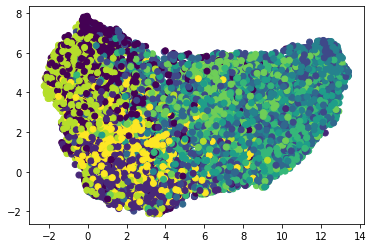

In [22]:

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_test)